# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, DataFrames
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, Plots.PlotMeasures
include("DA_kinetics.jl") # Loading of DA kinetics of gating variables
include("DA_models.jl") # Loading of DA model
include("DA_utils.jl"); # Loading of some utils functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 20000
const tspan  = (0.0, Tfinal)
tt = 0. : 0.01 : Tfinal
tt_rand = 0. : 1 : Tfinal
tt_plot = 0. : 0.01 : 20000.

# Definition of reversal potential values (in mV), [Mg] and membrane capacitance
const VNa     = 60. # Sodium reversal potential
const VK      = -90. # Potassium reversal potential
const VCa     = 50. # Calcium reversal potential
const VH      = -29. # H reversal potential
const VLNS    = -65. # Leak reversal potential
const EPacemaker = 4.2732015978991615 # Reversal potential of pacemaking channels

const C       = 1. # Membrane capacitance
const fCa     = 0.018 # Fraction of unbuffered free calcium
const ICapmax = 11 # Maximum calcium pump current
const F       = 96520 # Faraday constant in ms*µA/mmol (and taking cm³=mL)
const d       = 15 # Soma diameter in cm
const L       = 25 # Soma length

# Definition of voltage range for the DICs
const Vmin = -100 
const Vmax = 50
const Vrange = range(Vmin, stop=Vmax, step=0.0154640);

In [3]:
# Modifying backend GR attributes
gr(guidefontsize=25, tickfontsize=15, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1);
default(fmt = :png);

In [4]:
# Define a struct (optional, but useful if you need parameters)
struct NoisyFunction
    amplitude::Float64  # amplitude of the noise
end

# Overload the () operator to make the struct callable
function (nf::NoisyFunction)(x::Float64)
    noise = nf.amplitude * randn()  # Generate Gaussian noise (mean 0, std 1)
    return noise  # Example function with noise
end

function condition(u,t,integrator) # Event when event_f(u,t) == 0
  (u[1]- (-20.))
end

function affect!(integrator)
end

cb = ContinuousCallback(condition, affect!, nothing, save_positions = (true, false));

# Figure 4

In [7]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs.dat", freqs);

In [5]:
freqs = readdlm("./data/freqs.dat");

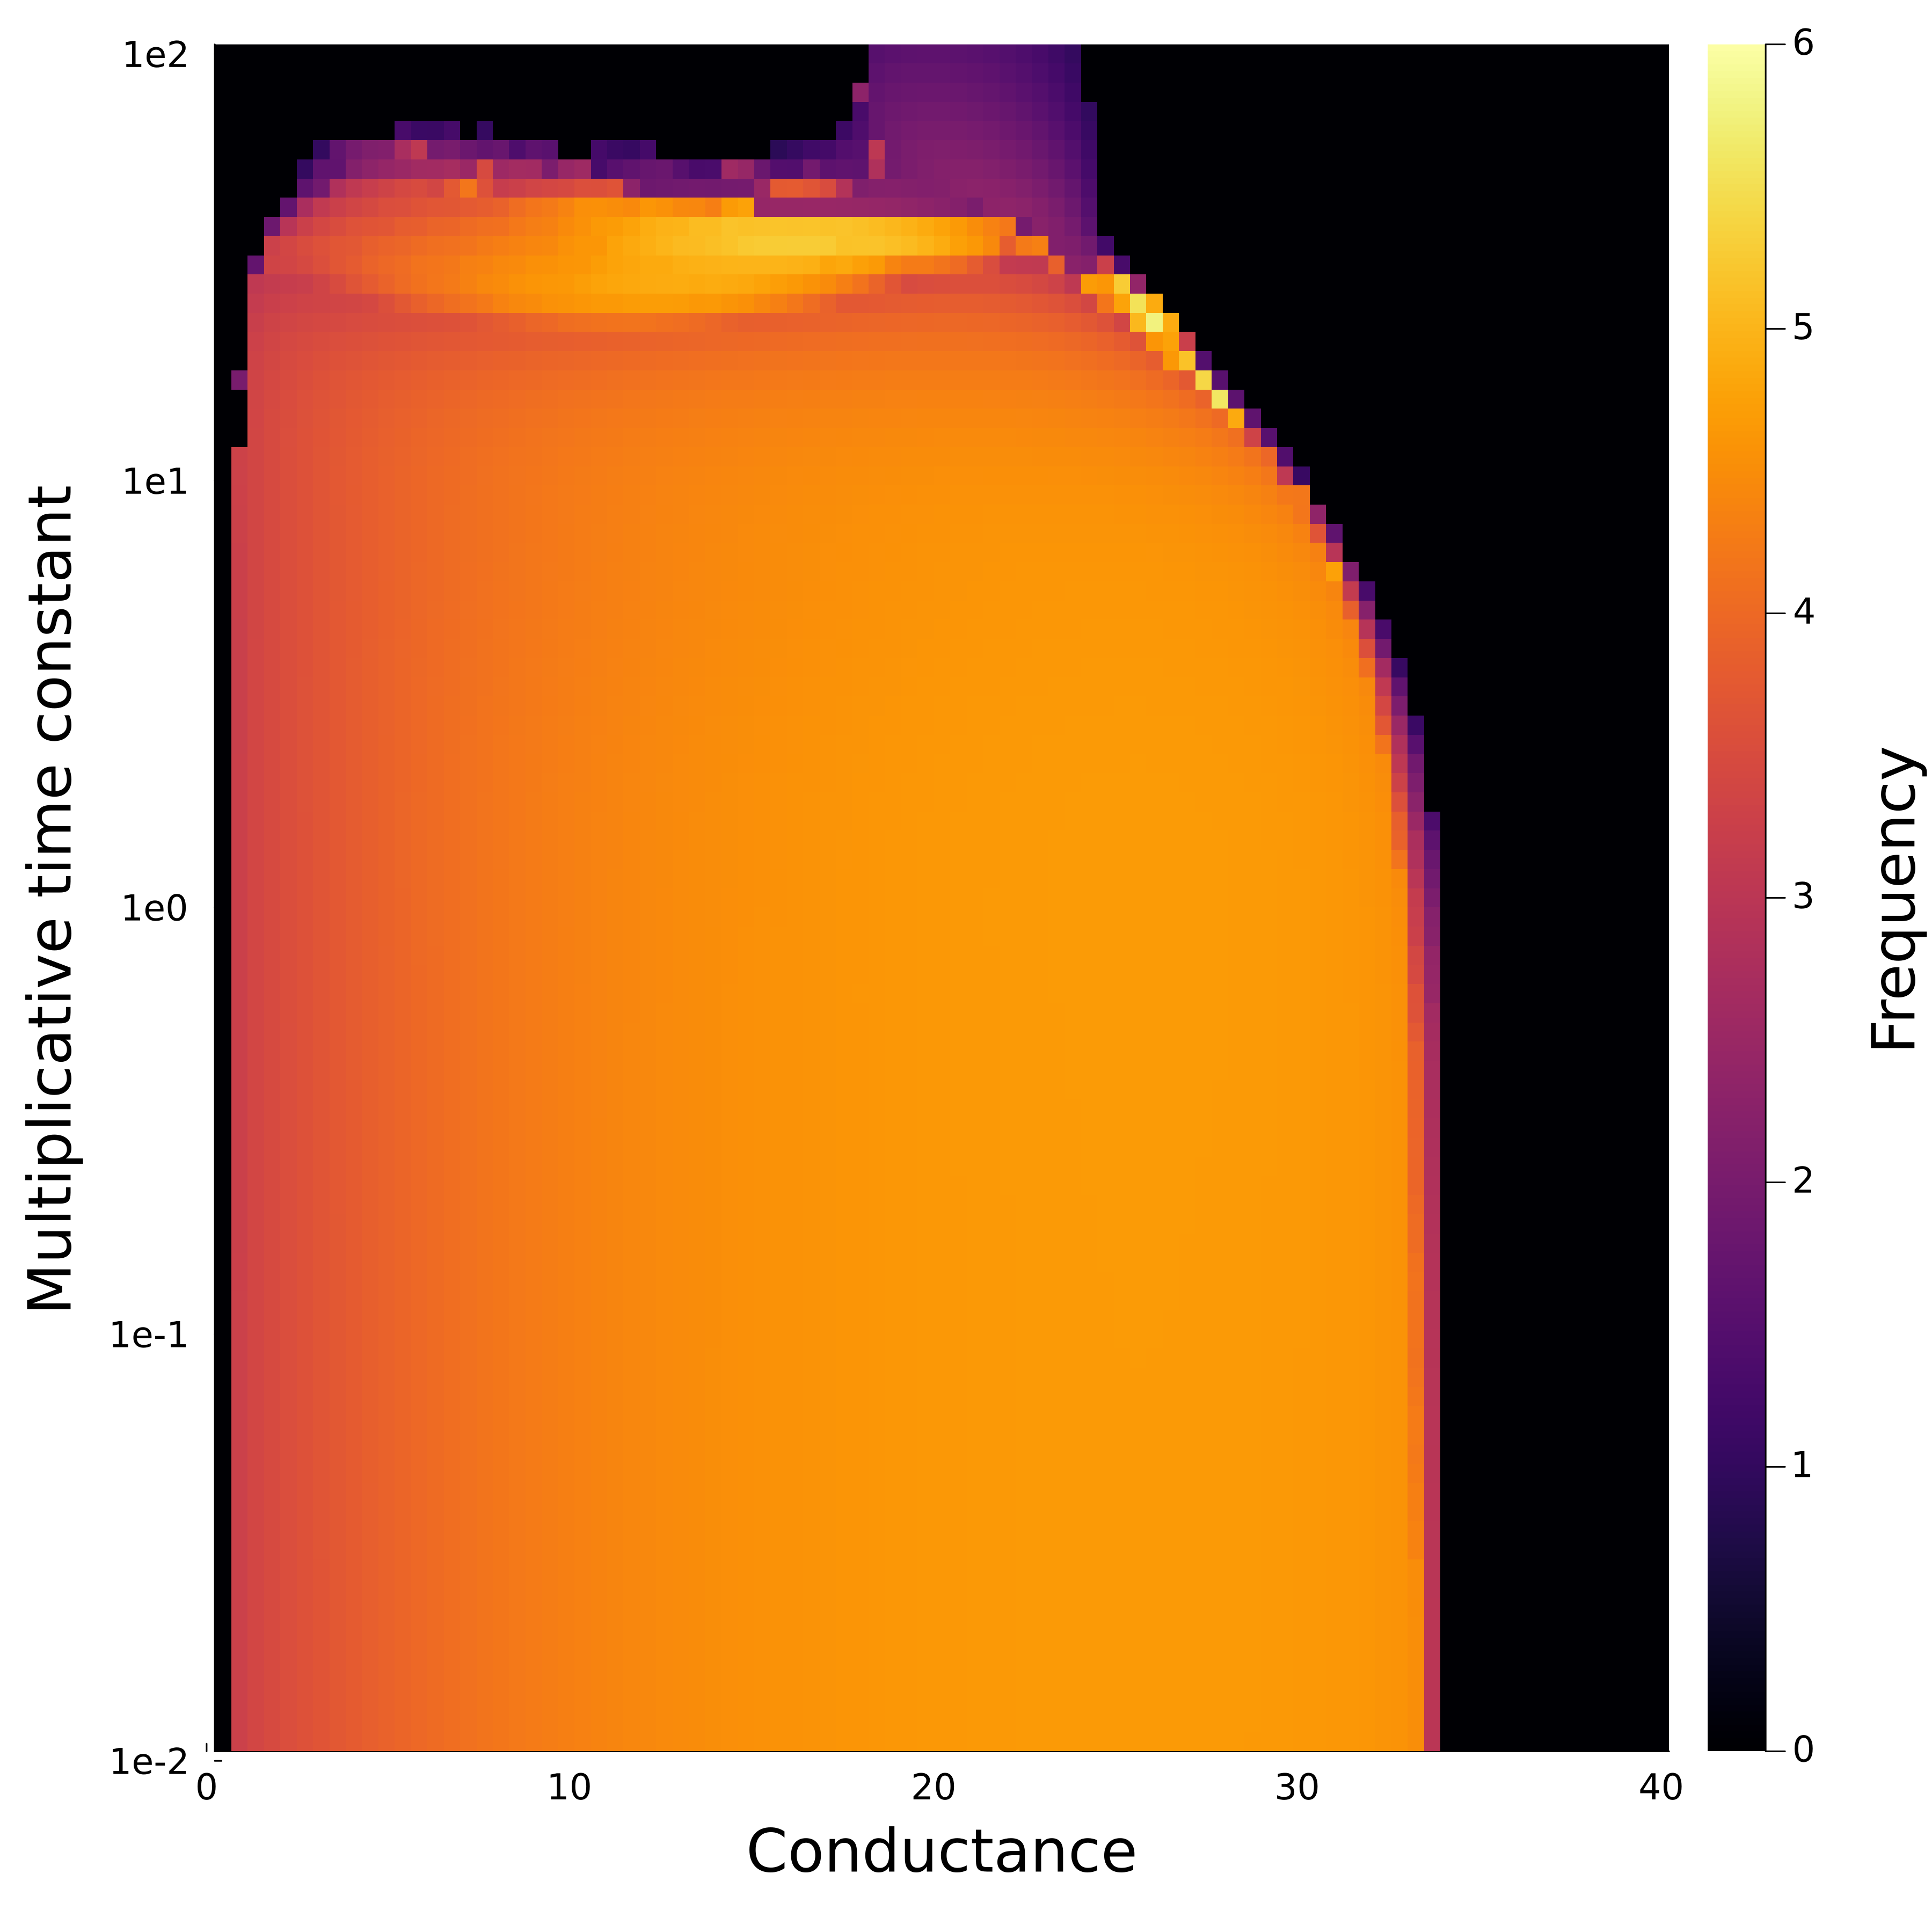

In [6]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
# savefig(h, "./figures/fig4_heatmap_g_and_tau_nonoise_all.png")
# savefig(h, "./figures/fig4_heatmap_g_and_tau_nonoise_all.pdf")
# savefig(h, "./figures/fig4_heatmap_g_and_tau_nonoise_all.svg")

In [10]:
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
i_spike = findall(freqs[:, 1] .> 0)
gPacemakers[i_spike]
display(minimum(gPacemakers[i_spike]))
display(maximum(gPacemakers[i_spike]))

0.45454545454545453

33.63636363636363

In [13]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0. # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0. # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0. # Leak calcium current maximal conductance

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs_NaKd = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob; maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs_NaKd[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs_NaKd[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs_NaKd[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_NaKd.dat", freqs_NaKd);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\arthu\.julia\packages\SciMLBase\l4PVV\src\integrator_interface.jl:606


40

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\arthu\.julia\packages\SciMLBase\l4PVV\src\integrator_interface.jl:606


41

42

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\arthu\.julia\packages\SciMLBase\l4PVV\src\integrator_interface.jl:606


43

44

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\arthu\.julia\packages\SciMLBase\l4PVV\src\integrator_interface.jl:606


45

46

47

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\arthu\.julia\packages\SciMLBase\l4PVV\src\integrator_interface.jl:606


48

49

50

51

52

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\arthu\.julia\packages\SciMLBase\l4PVV\src\integrator_interface.jl:606


53

54

55

56

57

58

59

60

61

62

63

64

65

66

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\arthu\.julia\packages\SciMLBase\l4PVV\src\integrator_interface.jl:606


67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

In [5]:
freqs_NaKd = readdlm("./data/freqs_NaKd.dat");

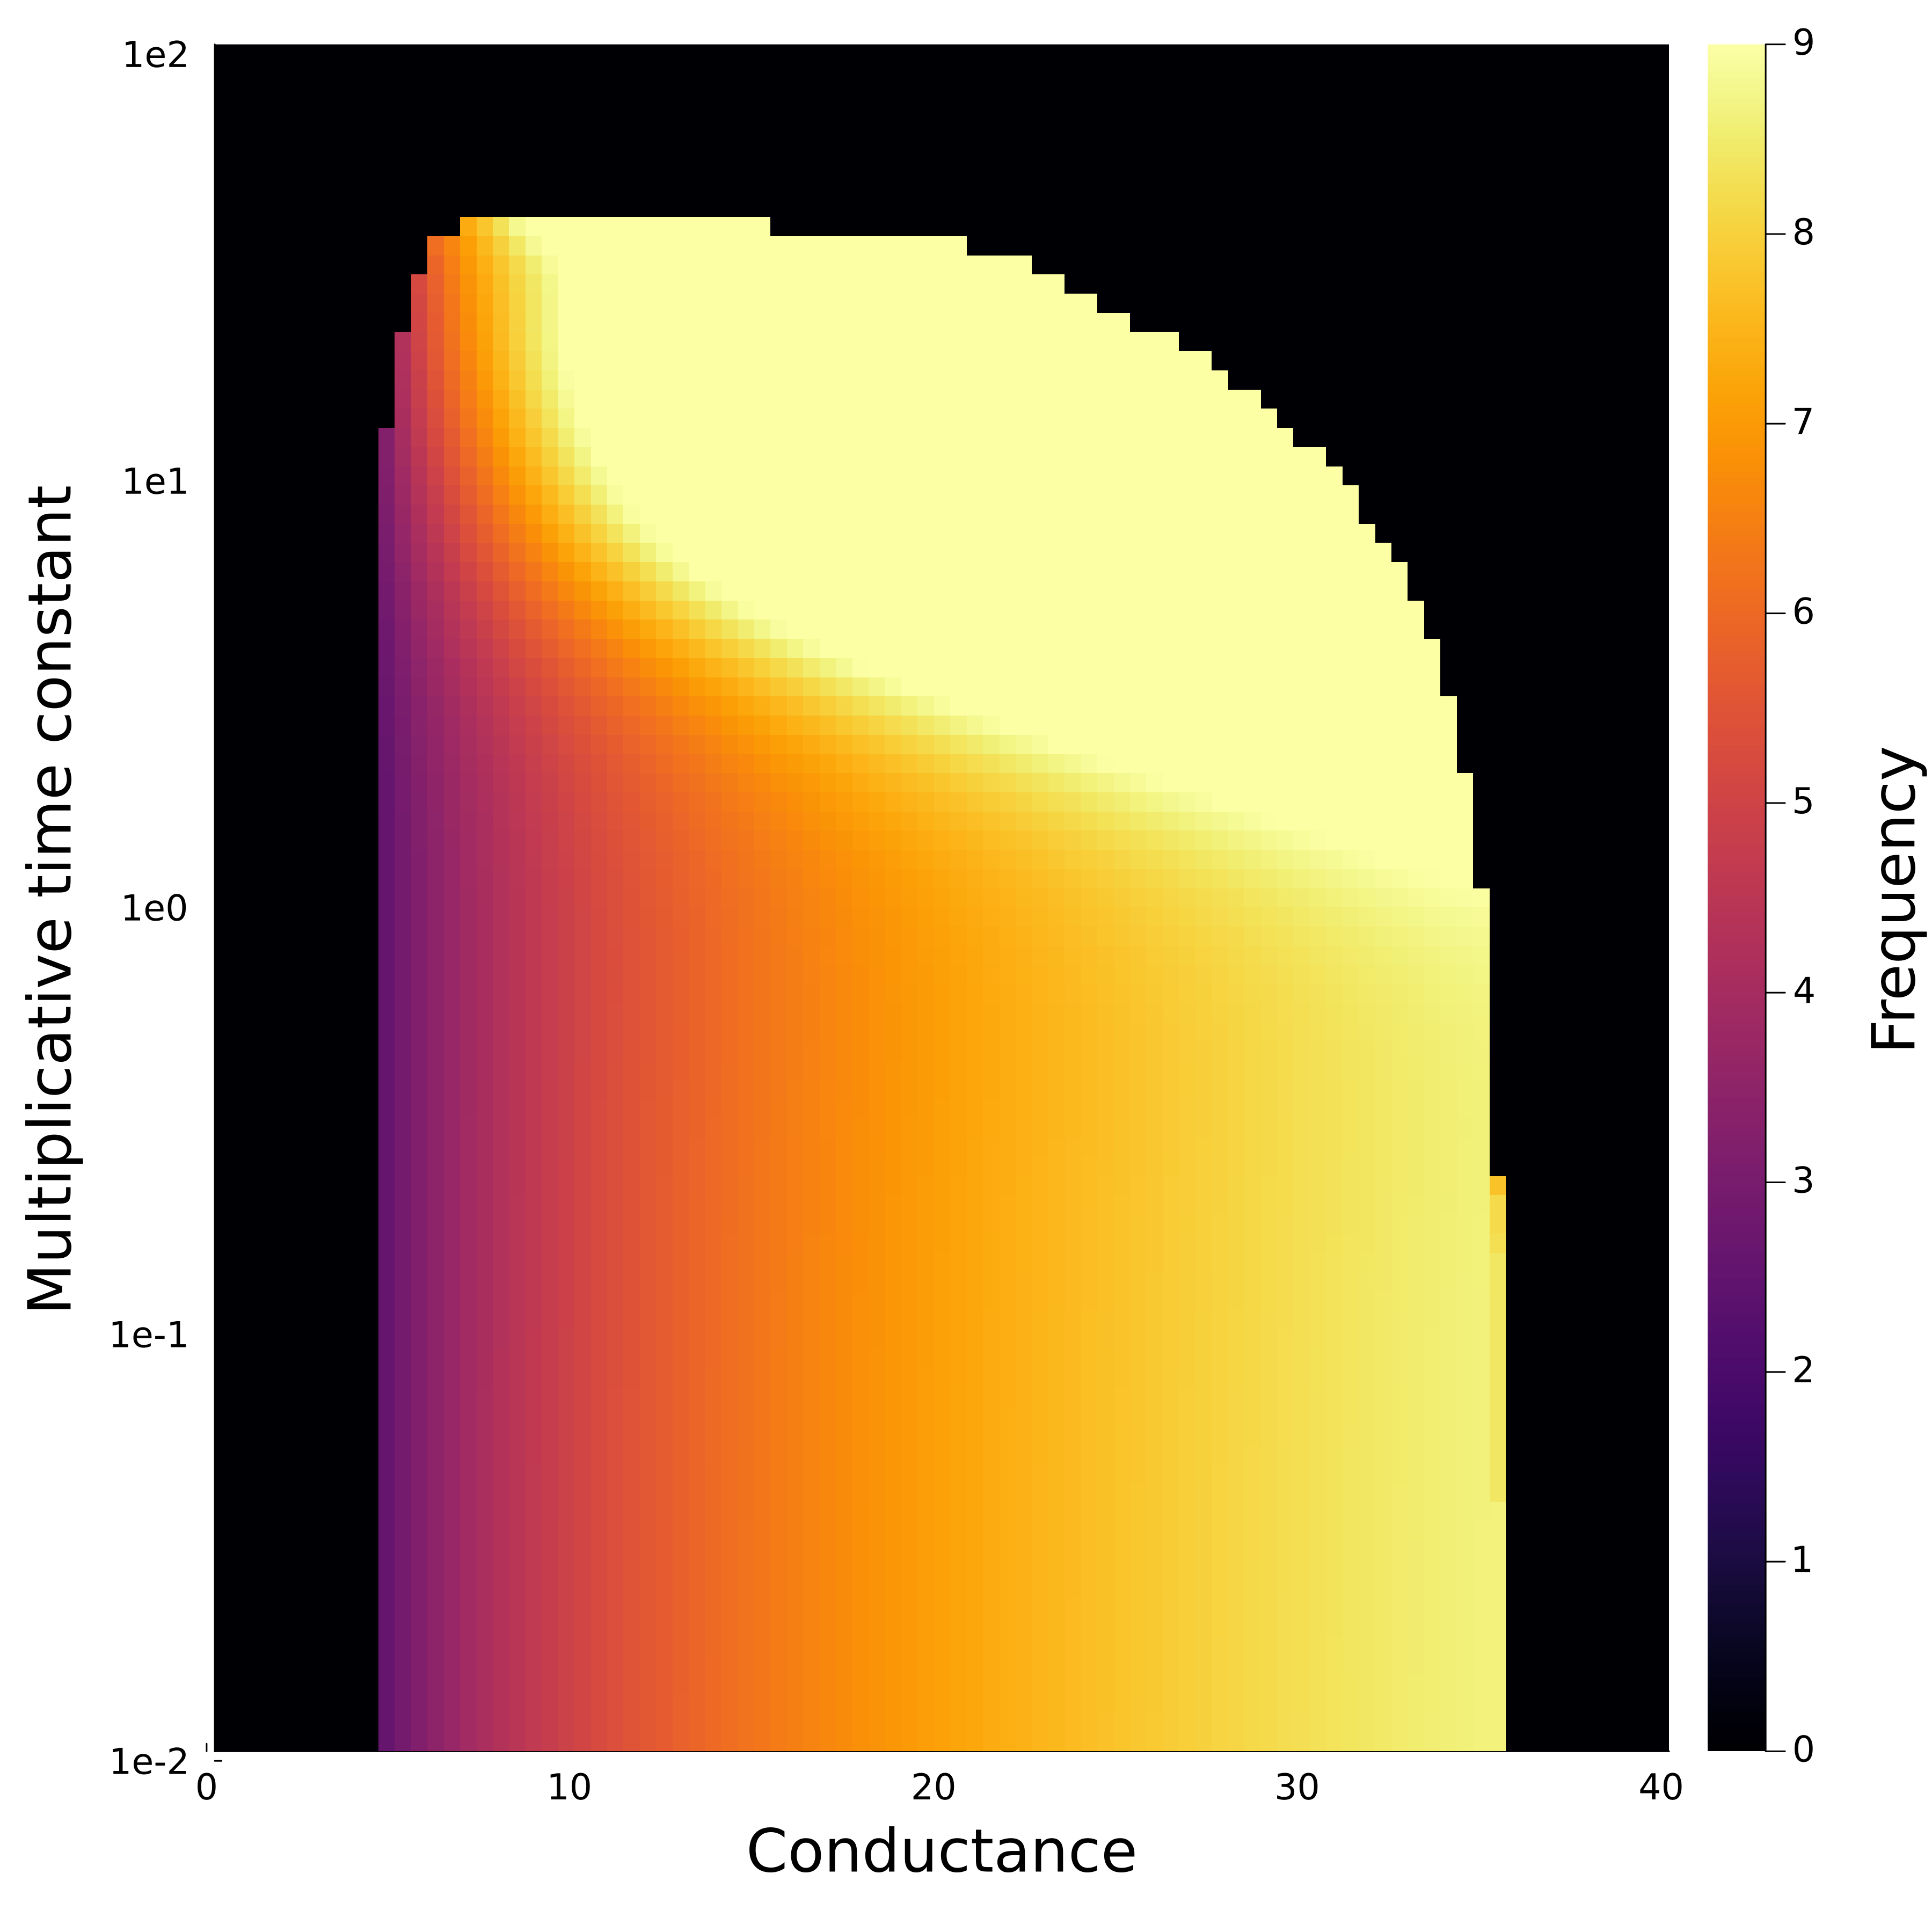

In [8]:
freqs_NaKd_nonan = deepcopy(freqs_NaKd)
freqs_NaKd_nonan[isnan.(freqs_NaKd)] .= 0
h = heatmap(freqs_NaKd_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 9),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
# savefig(h, "./figures/fig4_heatmap_g_and_tau_nonoise_NaKd.png")
# savefig(h, "./figures/fig4_heatmap_g_and_tau_nonoise_NaKd.pdf")
# savefig(h, "./figures/fig4_heatmap_g_and_tau_nonoise_NaKd.svg")

In [13]:
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
i_spike = findall(freqs_NaKd[:, 1] .> 0)
gPacemakers[i_spike]
display(minimum(gPacemakers[i_spike]))
display(maximum(gPacemakers[i_spike]))

4.545454545454546

35.45454545454545